# 「ベイズ推論による機械学習入門」
# P.149 ガウス混合モデルに対する変分推論

本書のサンプルコードを一部改変し、ガウス混合モデルに対するギブスサンプリング及びJuliaコードの書き方（コードを、情報を格納するオブジェクトのコンストラクタ、コンストラクタに格納した情報を渡し問題を解く関数の形式で整理して記述する）を理解する。

参考：https://github.com/sammy-suyama/BayesBook

In [1]:
using Distributions
using PDMats
using LinearAlgebra
using StatsFuns
using SpecialFunctions
using Plots

## パラメータを格納するコンストラクタを作成

In [2]:
# ガウス・ウィシャート分布
struct GW
    beta::Float64
    m::Vector{Float64}
    nu::Float64
    W::Matrix{Float64}
end

# ベイジアンガウス混合モデル
struct BGMM
    D::Int
    K::Int
    alpha::Vector{Float64}
    cmp::Vector{GW}
end

# ガウス分布
struct Gauss
    mu::Vector{Float64}
    Lambda::Matrix{Float64}
end

# ガウス混合モデル
struct GMM
    D::Int
    K::Int
    phi::Vector{Float64}
    cmp::Vector{Gauss}
end

## 観測データの生成

In [3]:
# ガウス混合モデルの超パラメータをサンプル
function sample_GMM(bgmm::BGMM)
    cmp = Vector{Gauss}()
    for c in bgmm.cmp
        Lambda = rand(Wishart(c.nu, PDMat(Symmetric(c.W))))
        mu = rand(MvNormal(c.m, PDMat(Symmetric(inv(c.beta * Lambda)))))
        push!(cmp, Gauss(mu, Lambda))
    end
    phi = rand(Dirichlet(bgmm.alpha))
    return GMM(bgmm.D, bgmm.K, phi, cmp)
end

sample_GMM (generic function with 1 method)

In [4]:
# ガウス混合モデルの潜在変数をサンプル
function categorical_sample(p::Vector{Float64}, N::Int)
    K = length(p)
    S = zeros(K, N)
    S_tmp = rand(Categorical(p), N)
    for k in 1:K
        for n in 1:N
            S_tmp[n] == k ? S[k,n] = 1 : S[k,n] = 0
        end
    end
    return S
end

categorical_sample (generic function with 1 method)

In [5]:
# ガウス混合モデルからデータをサンプル
function sample_data(gmm::GMM, N::Int)
    X = zeros(gmm.D, N)
    S = categorical_sample(gmm.phi, N)
    for n in 1:N
        k = argmax(S[:, n])
        X[:, n] = rand(MvNormal(gmm.cmp[k].mu, PDMat(Symmetric(inv(gmm.cmp[k].Lambda)))))
    end
    return X, S
end


sample_data (generic function with 1 method)

## 変分推論

### 初期化

In [6]:
# 潜在変数Sの初期化
function init_S(X::Matrix{Float64}, bgmm::BGMM)
    N = size(X, 2)
    K = bgmm.K
    S = categorical_sample(ones(K)/K, N)    
    return S
end

init_S (generic function with 1 method)

In [7]:
# パラメータμ, Λ, πの初期化
function add_stats(bgmm::BGMM, X::Matrix{Float64}, S::Matrix{Float64})
    D = bgmm.D
    K = bgmm.K
    sum_S = sum(S, dims=2)
    alpha = [bgmm.alpha[k] + sum_S[k] for k in 1:K]
    cmp = Vector{GW}()
    
    for k in 1:K
        beta = bgmm.cmp[k].beta + sum_S[k]
        m = (1.0 / beta) * (vec(X * S[[k],:]') + bgmm.cmp[k].beta * bgmm.cmp[k].m)
        nu = bgmm.cmp[k].nu + sum_S[k]
        W = inv(X * diagm(S[k,:]) * X'
                          - beta * m * m'
                          + bgmm.cmp[k].beta * bgmm.cmp[k].m * bgmm.cmp[k].m'
                          + inv(bgmm.cmp[k].W))
                
        push!(cmp, GW(beta, m, nu, W))
    end
    return BGMM(D, K, alpha, cmp)
end

add_stats (generic function with 1 method)

### 更新即

In [8]:
function sumdigamma(nu, D)
    ret = 0.0
    for d in 1:D
        ret += digamma.(0.5 * (nu + 1 - d))
    end
    return ret
end

sumdigamma (generic function with 1 method)

In [9]:
# 潜在変数の更新
function update_S(bgmm::BGMM, X::Matrix{Float64})
    D, N = size(X)
    K = bgmm.K
    ln_S = zeros(K, N)
    tmp = zeros(K)

    tmp = NaN * zeros(K)
    sum_digamma_tmp = digamma.(sum(bgmm.alpha))
    for k in 1:K
        tmp[k] = -0.5 * (bgmm.cmp[k].nu * tr(bgmm.cmp[k].m * bgmm.cmp[k].m' * bgmm.cmp[k].W)
                        + D * (1.0 / bgmm.cmp[k].beta)
                        - (sumdigamma(bgmm.cmp[k].nu, D) + logdet(bgmm.cmp[k].W)))
        tmp[k] += digamma.(bgmm.alpha[k]) - sum_digamma_tmp
    end
    
    for n in 1:N
        tmp_ln_pi = NaN * zeros(K)
        for k in 1 : K
            tmp_ln_pi[k] = tmp[k] - bgmm.cmp[k].nu * (-0.5 * tr(X[:,n] * X[:,n]' * bgmm.cmp[k].W) + X[:,n]' * bgmm.cmp[k].W * bgmm.cmp[k].m)
        end
        ln_S[:,n] = tmp_ln_pi .- logsumexp(tmp_ln_pi)
    end
    return ln_S
end

update_S (generic function with 1 method)

In [10]:
# 変分推論
function learn_VI(X::Matrix{Float64}, prior_bgmm::BGMM, max_iter::Int)
    # 近似分布の初期化
    expt_S = init_S(X, prior_bgmm)
    bgmm = add_stats(prior_bgmm, X, expt_S)
    
    # 推論
    for i in 1 : max_iter
        # E-step
        expt_S = exp.(update_S(bgmm, X))
        # M-step
        bgmm = add_stats(prior_bgmm, X, expt_S)
    end

    return S, bgmm
end

learn_VI (generic function with 1 method)

## 2次元データのクラスタリング

In [11]:
D = 2 # データの次元数
K = 4 # 混合成分の数
alpha = 100 * ones(K)
beta = 0.1
m = zeros(D)
nu = D + 1.0
W = Matrix(1.0I, D, D)
cmp = [GW(beta, m, nu, W) for _ in 1:K]
bgmm = BGMM(D, K, alpha, cmp)
    
# データ生成
N = 300
gmm = sample_GMM(bgmm)
X, S = sample_data(gmm, N)
    
# 推論
max_iter = 100
S_est, post_bgmm = learn_VI(X, bgmm, max_iter);

In [12]:
function visualize_2D(X::Matrix{Float64}, S::Matrix{Float64}, S_est::Matrix{Float64})
    K1 = size(S, 1)
    K2 = size(S_est, 1)
    
    p1 = plot(xlab="x1", ylab="x2")
    p2 = plot(xlab="x1", ylab="x2") 
    
    for k in 1:K1
        scatter!(p1, X[1, S[k, :] .== 1], X[2, S[k, :] .== 1], label="cluster $k", title="Truth")
    end
    
    for k in 1:K2
        scatter!(p2, X[1, S_est[k, :] .== 1], X[2, S_est[k, :] .== 1], label="cluster $k", title="Estimation")
    end
    
    return p1, p2
    
end

visualize_2D (generic function with 1 method)

In [13]:
p1, p2 = visualize_2D(X, S, S_est);

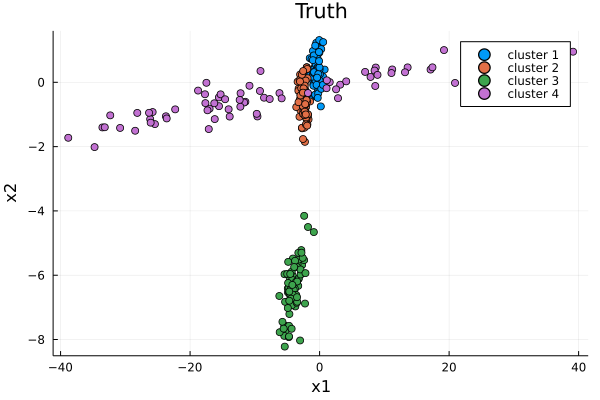

In [14]:
p1

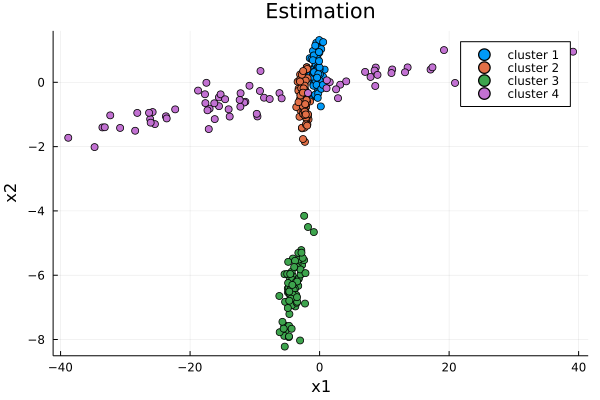

In [15]:
p2